In [1]:
import sys
import numpy as np
import pandas as pd
# import pyqtgraph as pg
import cnmodel as cnm
from cnmodel import populations
from cnmodel.protocols import IVCurve
from neuron import h
import matplotlib.pyplot as plt
import scipy

--No graphics will be displayed.


In [6]:
curs = np.linspace(-0.15, 0.16, 30)
curs[1] - curs[0]

np.float64(0.010689655172413798)

In [39]:
len(np.arange(-0.1, 0.21, 0.0106))

30

## IC

In [45]:
ic_cell = cnm.cells.IC.create() #,species='mouse')
v0 = ic_cell.find_i0(showinfo=True)
ic_cell.set_temperature(float(34))
iv = IVCurve()
iv.reset()
iv.run({'pulse': [(-0.1, 0.21, 0.0106)]},
       ic_cell, durs=[250, 500, 200],
       sites=None, reppulse=None, temp=float(34))


  [soma] find_i0  Species: mouse  cell type: I-c  Temp   22.0
    *** found V0 = -63.928681
    *** and cell has mechanisms:  ['kht', 'ka', 'ihvcn', 'leak', 'nacn']


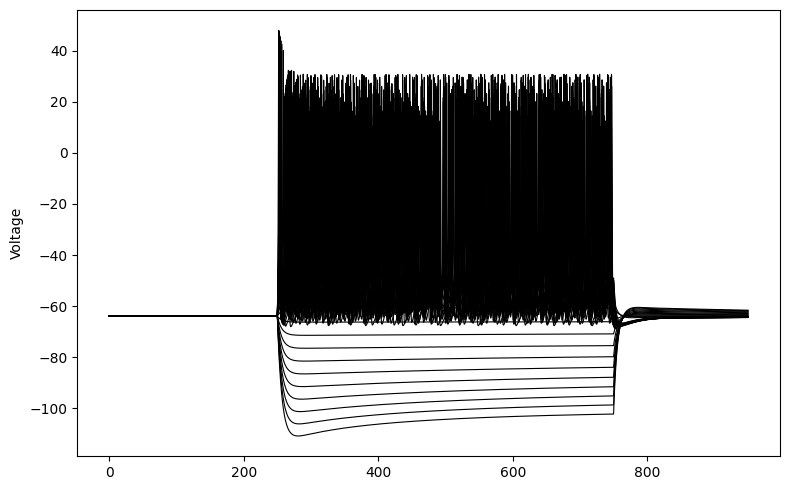

In [46]:
fig, axs = plt.subplots(1,1, figsize=(8,5))
# axs.ravel()

for i, voltage_trace in enumerate(iv.voltage_traces):

    axs.plot(iv.time_values, voltage_trace, color='k', linewidth=0.8)
    # axs[1].plot(iv.time_values, iv.current_traces[i])

# plt.plot(iv.voltage_traces[0], iv.current_traces[0])
# axs[0].set_xlim([350,950])
# axs[1].set_xlim([350,950])
axs.set_ylabel('Voltage')
# axs[1].set_ylabel('Current')
# axs[1].set_xlabel('Time')

fig.tight_layout()
# fig.savefig('ic_curret_step.pdf', dpi=300)

## Pyramidal


  [soma] find_i0  Species: rat  cell type: pyramidal  Temp   32.0
    *** found V0 = -62.496552
    *** and cell has mechanisms:  ['napyr', 'kdpyr', 'kif', 'kis', 'ihpyr', 'leak']


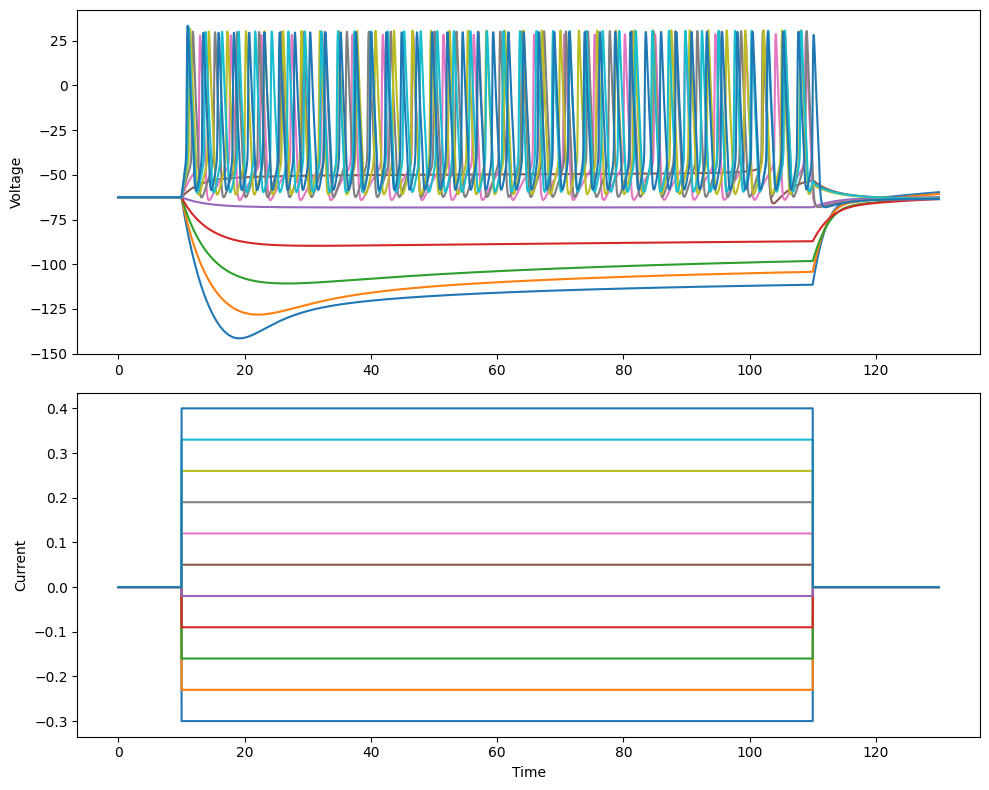

In [5]:
pyramidal_cell = cnm.cells.Pyramidal.create() #,species='mouse')
v0 = pyramidal_cell.find_i0(showinfo=True)
pyramidal_cell.set_temperature(float(34))
iv = IVCurve()
iv.reset()
iv.run({'pulse': [(-0.3, 0.45, 0.07)]},
       pyramidal_cell, durs=[10, 100, 20],
       sites=None, reppulse=None, temp=float(34))

fig, axs = plt.subplots(2,1, figsize=(10,8))
axs.ravel()

for i, voltage_trace in enumerate(iv.voltage_traces):

    axs[0].plot(iv.time_values, voltage_trace)
    axs[1].plot(iv.time_values, iv.current_traces[i])

# plt.plot(iv.voltage_traces[0], iv.current_traces[0])
# axs[0].set_xlim([350,950])
# axs[1].set_xlim([350,950])
axs[0].set_ylabel('Voltage')
axs[1].set_ylabel('Current')
axs[1].set_xlabel('Time')

fig.tight_layout()

## Vertical

getcellpars: modelType:  TVmouse

  [soma] find_i0  Species: mouse  cell type: TVmouse  Temp   34.0
    *** found V0 = -68.598171
    *** and cell has mechanisms:  ['kht', 'ka', 'ihvcn', 'leak', 'nacncoop']


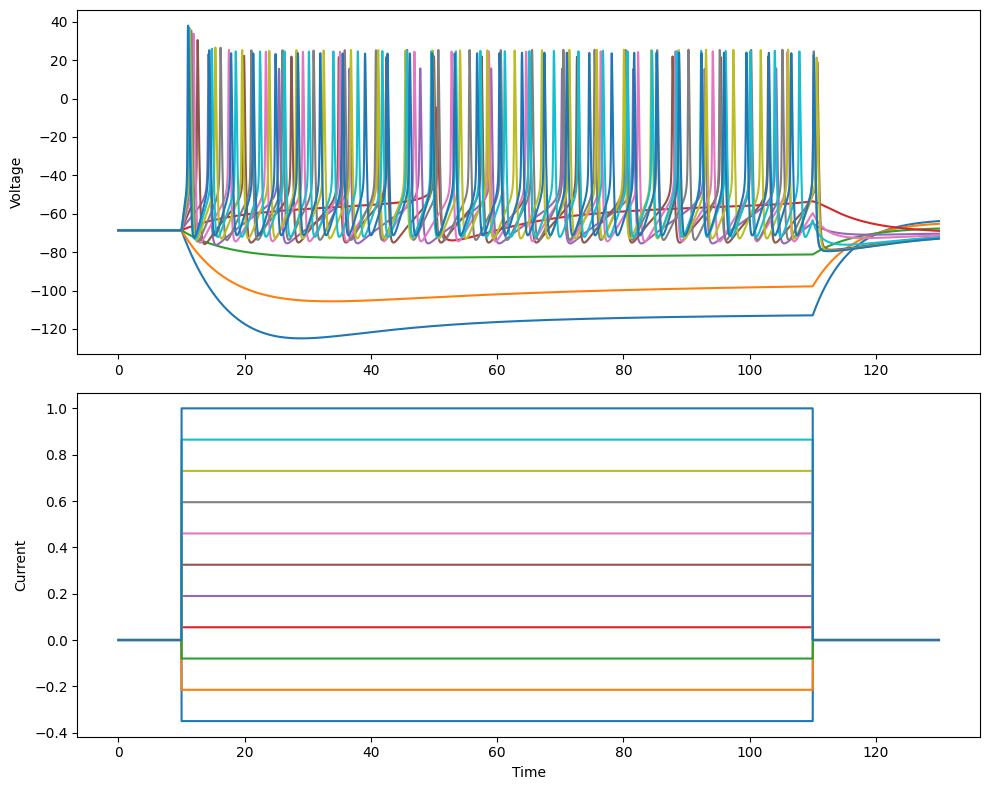

In [6]:
vertical_cell = cnm.cells.Tuberculoventral.create() #,species='mouse')
v0 = vertical_cell.find_i0(showinfo=True)
vertical_cell.set_temperature(float(34))
iv = IVCurve()
iv.reset()
iv.run({'pulse': [(-0.35, 1.0, 0.135)]},
       vertical_cell, durs=[10, 100, 20],
       sites=None, reppulse=None, temp=float(34))

fig, axs = plt.subplots(2,1, figsize=(10,8))
axs.ravel()

for i, voltage_trace in enumerate(iv.voltage_traces):

    axs[0].plot(iv.time_values, voltage_trace)
    axs[1].plot(iv.time_values, iv.current_traces[i])

# plt.plot(iv.voltage_traces[0], iv.current_traces[0])
# axs[0].set_xlim([350,950])
# axs[1].set_xlim([350,950])
axs[0].set_ylabel('Voltage')
axs[1].set_ylabel('Current')
axs[1].set_xlabel('Time')

fig.tight_layout()

## NS -> IC -> Pyr

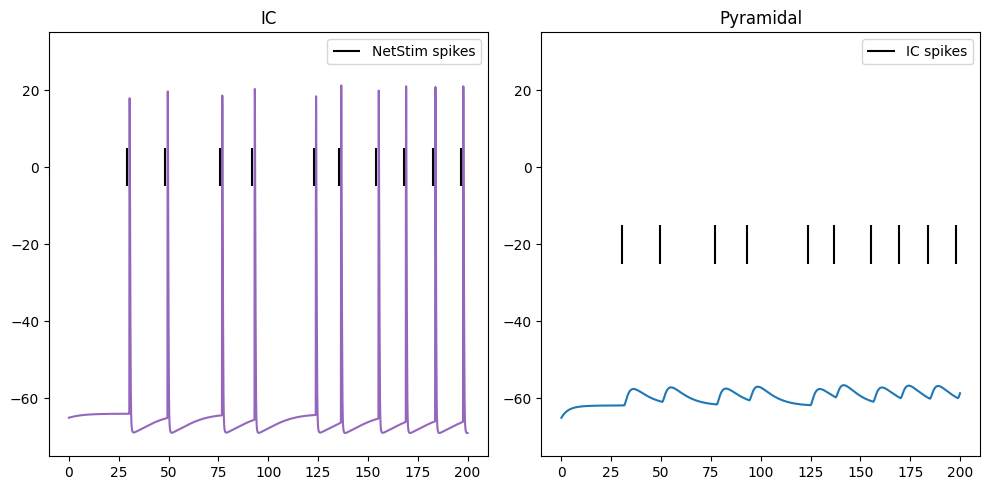

In [3]:
# cf = 16e3
# pyramidal_id = pyramidal.select(1, cf=cf, create=True)
# pyramidal_cell = pyramidal.get_cell(pyramidal_id)[0]

ic_cell = cnm.cells.TStellate.create(modelType='I-c')
pyramidal_cell = cnm.cells.Pyramidal.create()

ic_v = h.Vector().record(ic_cell.soma(0.5)._ref_v)
pyramidal_v = h.Vector().record(pyramidal_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

ns = h.NetStim()
ns.interval = 1000/40  # 80 Hz
ns.number = 2e9
ns.start = 20
ns.noise = 0.5
ns.seed(74)

stim_t = h.Vector()
stim_id = h.Vector()
e_syn = h.ExpSyn(ic_cell.soma(0.5))
nc = h.NetCon(ns, e_syn)
nc.weight[0] = 1
nc.record(stim_t, stim_id)

e_syn_pyr = h.Exp2Syn(pyramidal_cell.soma(0.5))
e_syn_pyr.tau1 = 0.5464  # 0.1 default   # 10
e_syn_pyr.tau2 = 6
# e_syn_pyr.tau2 = 2

nc_pyr = h.NetCon(ic_cell.soma(0.5)._ref_v, e_syn_pyr, sec=ic_cell.soma)
nc_pyr.weight[0] = 0.0005


stim_t_pyr = h.Vector()
stim_id_pyr = h.Vector()
nc_pyr.record(stim_t_pyr, stim_id_pyr)

h.tstop = 0.2*1000
h.dt = 0.025
h.celsius = 34.0

cnm.util.custom_init()
h.run()

fig, axs = plt.subplots(1,2,figsize=(10,5))  #, sharey=True)
axs.ravel()

axs[0].plot(t, ic_v, color='tab:purple')
axs[0].vlines(list(stim_t), ymin=-5, ymax=5, color='k', label='NetStim spikes')
axs[0].set_title('IC')
axs[0].legend(loc='upper right')
axs[0].set_ylim([-75, 35])

axs[1].plot(t, pyramidal_v, color='tab:blue')
axs[1].vlines(list(stim_t_pyr), ymin=-25, ymax=-15, color='k', label='IC spikes')
axs[1].set_title(f'Pyramidal')
axs[1].legend(loc='upper right')
axs[1].set_ylim([-75, 35])

fig.tight_layout()

## NS -> IC -> Vertical

getcellpars: modelType:  TVmouse


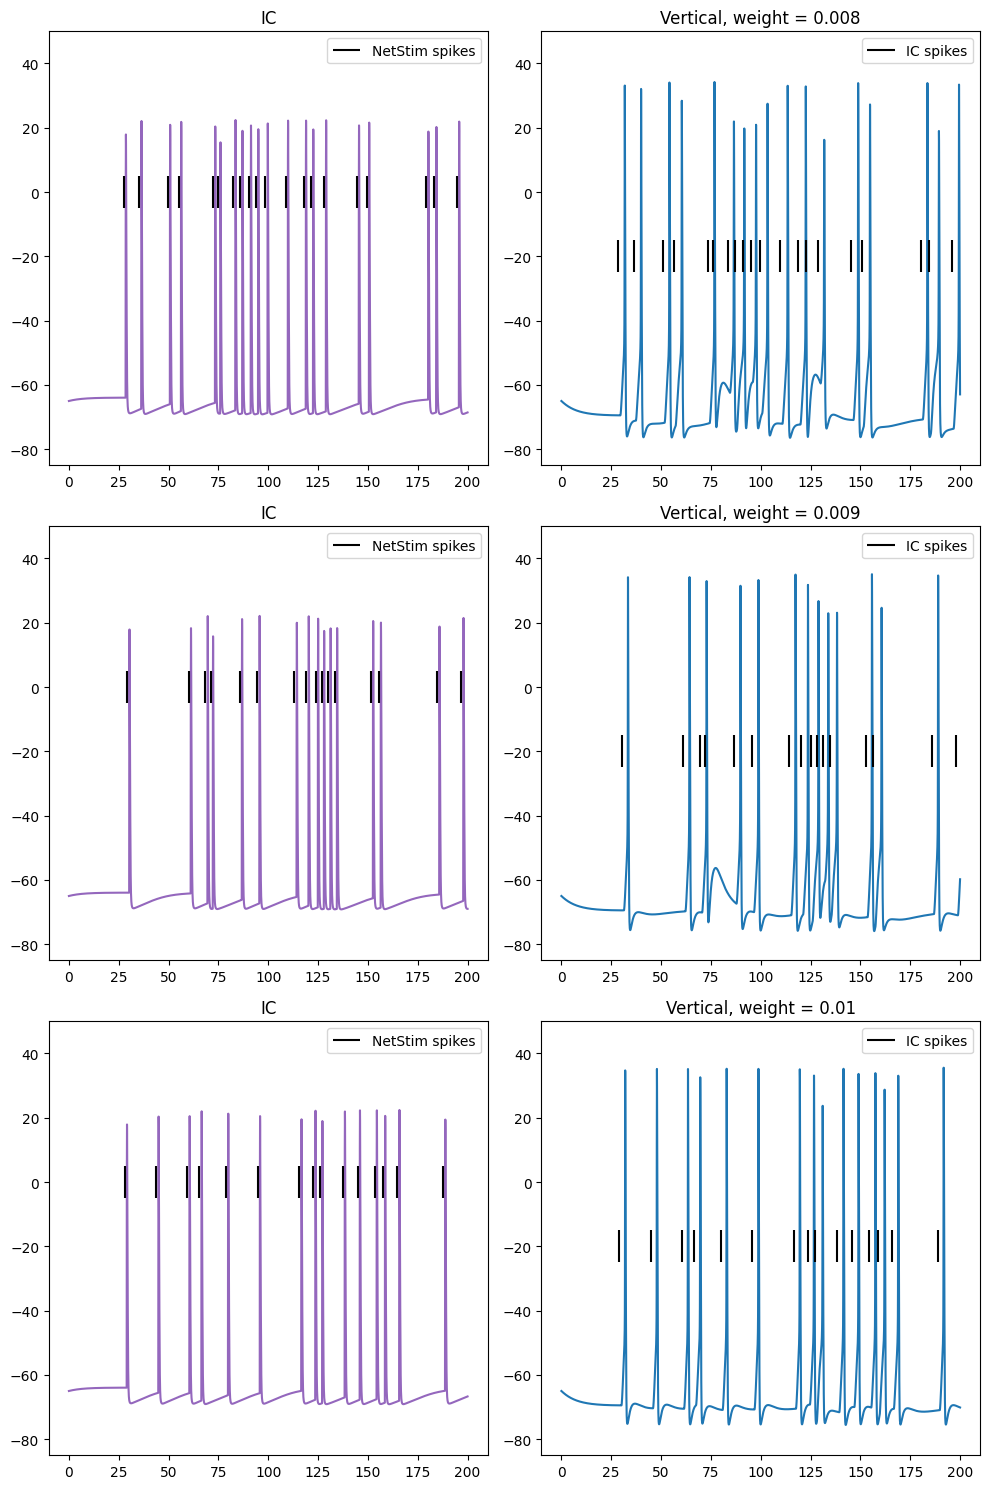

In [15]:
# cf = 16e3
# pyramidal_id = pyramidal.select(1, cf=cf, create=True)
# pyramidal_cell = pyramidal.get_cell(pyramidal_id)[0]

ic_cell = cnm.cells.TStellate.create(modelType='I-c')
vertical_cell = cnm.cells.Tuberculoventral.create()

ic_v = h.Vector().record(ic_cell.soma(0.5)._ref_v)
vertical_v = h.Vector().record(vertical_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

ns = h.NetStim()
ns.interval = 1000/80  # 80 Hz
ns.number = 2e9
ns.start = 20
ns.noise = 0.8
ns.seed(74)

stim_t = h.Vector()
stim_id = h.Vector()
e_syn = h.ExpSyn(ic_cell.soma(0.5))
nc = h.NetCon(ns, e_syn)
nc.weight[0] = 1
nc.record(stim_t, stim_id)

e_syn_vert = h.Exp2Syn(vertical_cell.soma(0.5))
e_syn_vert.tau1 = 0.5464  # 0.1 default   # 10
e_syn_vert.tau2 = 2.5
# e_syn_pyr.tau2 = 2

weights = [0.008, 0.009, 0.01]

fig, axs = plt.subplots(len(weights),2,figsize=(10,5*len(weights)))  #, sharey=True)
# axs = axs.ravel()

for i, weight in enumerate(weights):

    if len(weights) > 1:
        ax_l = axs[i,0]
        ax_r = axs[i,1]
    else:
        ax_l = axs[0]
        ax_r = axs[1]

    nc_vert = h.NetCon(ic_cell.soma(0.5)._ref_v, e_syn_vert, sec=ic_cell.soma)
    nc_vert.weight[0] = weight
    # nc_vert.delay = 0

    stim_t_vert = h.Vector()
    stim_id_vert = h.Vector()
    nc_vert.record(stim_t_vert, stim_id_vert)

    h.tstop = 0.2*1000
    h.dt = 0.025
    h.celsius = 34.0

    cnm.util.custom_init()
    h.run()

    ax_l.plot(t, ic_v, color='tab:purple')
    ax_l.vlines(list(stim_t), ymin=-5, ymax=5, color='k', label='NetStim spikes')
    ax_l.set_title('IC')
    ax_l.legend(loc='upper right')
    ax_l.set_ylim([-85, 50])

    ax_r.plot(t, vertical_v, color='tab:blue')
    ax_r.vlines(list(stim_t_vert), ymin=-25, ymax=-15, color='k', label='IC spikes')
    ax_r.set_title(f'Vertical, weight = {weight}')
    ax_r.legend(loc='upper right')
    ax_r.set_ylim([-85, 50])

fig.tight_layout()

## NS -> Pyr -> IC

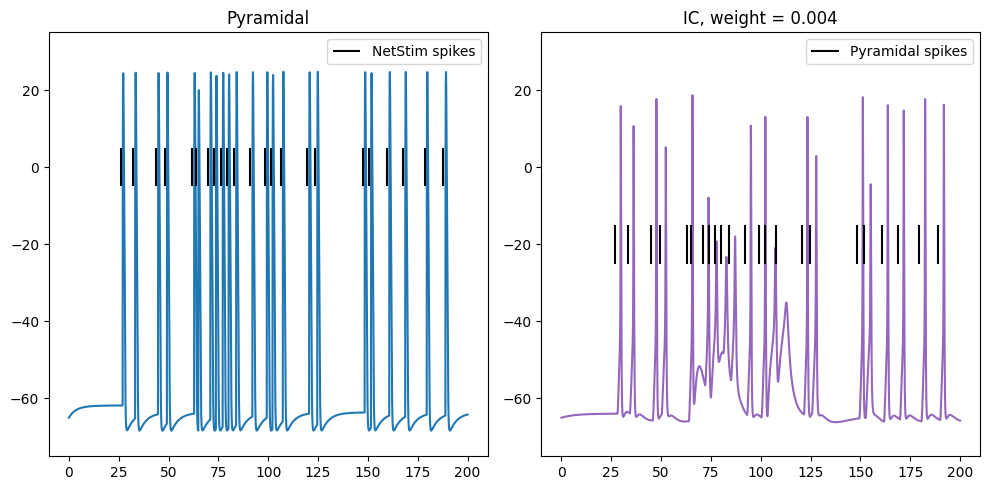

In [5]:
# cf = 16e3
# pyramidal_id = pyramidal.select(1, cf=cf, create=True)
# pyramidal_cell = pyramidal.get_cell(pyramidal_id)[0]

ic_cell = cnm.cells.TStellate.create(modelType='I-c')
pyramidal_cell = cnm.cells.Pyramidal.create()

ic_v = h.Vector().record(ic_cell.soma(0.5)._ref_v)
pyramidal_v = h.Vector().record(pyramidal_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

ns = h.NetStim()
ns.interval = 1000/100  # 80 Hz
ns.number = 2e9
ns.start = 20
ns.noise = 0.8
ns.seed(74)

stim_t = h.Vector()
stim_id = h.Vector()
e_syn = h.ExpSyn(pyramidal_cell.soma(0.5))
nc = h.NetCon(ns, e_syn)
nc.weight[0] = 1
nc.record(stim_t, stim_id)

e_syn_ic = h.Exp2Syn(ic_cell.soma(0.5))
e_syn_ic.tau1 = 0.5464  # 0.1 default   # 10
e_syn_ic.tau2 = 1.5

nc_ic = h.NetCon(pyramidal_cell.soma(0.5)._ref_v, e_syn_ic, sec=pyramidal_cell.soma)


weights = [0.004]  # np.linspace(0.002,0.008,7)
# tau2s = np.linspace(1,2,7)

fig, axs = plt.subplots(len(weights),2,figsize=(10,len(weights)*5))  #, sharey=True)
    # axs.ravel()


for i, weight in enumerate(weights):

    if len(weights) > 1:
        ax_l = axs[i,0]
        ax_r = axs[i,1]
    else:
        ax_l = axs[0]
        ax_r = axs[1]
    
    nc_ic.weight[0] = weight  # 0.0015 causes spiking

    stim_t_ic = h.Vector()
    stim_id_ic = h.Vector()
    nc_ic.record(stim_t_ic, stim_id_ic)

    h.tstop = 0.2*1000
    h.dt = 0.025
    h.celsius = 34.0

    cnm.util.custom_init()
    h.run()

    ax_l.plot(t, pyramidal_v, color='tab:blue')
    ax_l.vlines(list(stim_t), ymin=-5, ymax=5, color='k', label='NetStim spikes')
    ax_l.set_title(f'Pyramidal')
    ax_l.legend(loc='upper right')
    ax_l.set_ylim([-75, 35])

    ax_r.plot(t, ic_v, color='tab:purple')
    ax_r.vlines(list(stim_t_ic), ymin=-25, ymax=-15, color='k', label='Pyramidal spikes')
    ax_r.set_title(f'IC, weight = {weight}')
    ax_r.legend(loc='upper right')
    ax_r.set_ylim([-75, 35])

fig.tight_layout()

## NS -> PYR -> IC -> PYR

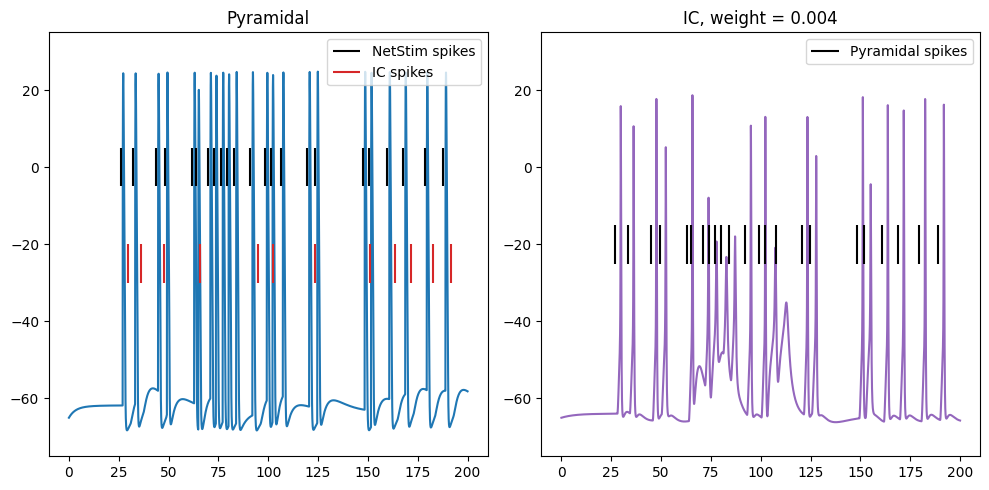

In [2]:
# cf = 16e3
# pyramidal_id = pyramidal.select(1, cf=cf, create=True)
# pyramidal_cell = pyramidal.get_cell(pyramidal_id)[0]

ic_cell = cnm.cells.TStellate.create(modelType='I-c')
pyramidal_cell = cnm.cells.Pyramidal.create()

ic_v = h.Vector().record(ic_cell.soma(0.5)._ref_v)
pyramidal_v = h.Vector().record(pyramidal_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

ns = h.NetStim()
ns.interval = 1000/100  # 80 Hz
ns.number = 2e9
ns.start = 20
ns.noise = 0.8
ns.seed(74)

stim_t = h.Vector()
stim_id = h.Vector()
e_syn = h.ExpSyn(pyramidal_cell.soma(0.5))
nc = h.NetCon(ns, e_syn)
nc.weight[0] = 1
nc.record(stim_t, stim_id)

e_syn_ic = h.Exp2Syn(ic_cell.soma(0.5))
e_syn_ic.tau1 = 0.5464  # 0.1 default   # 10
e_syn_ic.tau2 = 1.5

nc_ic = h.NetCon(pyramidal_cell.soma(0.5)._ref_v, e_syn_ic, sec=pyramidal_cell.soma)
stim_t_ic = h.Vector()
stim_id_ic = h.Vector()
nc_ic.record(stim_t_ic, stim_id_ic)

e_syn_pyr = h.Exp2Syn(pyramidal_cell.soma(0.5))
e_syn_pyr.tau1 = 0.5464  # 0.1 default   # 10
e_syn_pyr.tau2 = 6
# e_syn_pyr.tau2 = 2

nc_pyr = h.NetCon(ic_cell.soma(0.5)._ref_v, e_syn_pyr, sec=ic_cell.soma)
nc_pyr.weight[0] = 0.0005
stim_t_pyr = h.Vector()
stim_id_pyr = h.Vector()
nc_pyr.record(stim_t_pyr, stim_id_pyr)


weights = [0.004]  # np.linspace(0.002,0.008,7)
# tau2s = np.linspace(1,2,7)

fig, axs = plt.subplots(len(weights),2,figsize=(10,len(weights)*5))  #, sharey=True)
    # axs.ravel()

for i, weight in enumerate(weights):

    if len(weights) > 1:
        ax_l = axs[i,0]
        ax_r = axs[i,1]
    else:
        ax_l = axs[0]
        ax_r = axs[1]
    
    nc_ic.weight[0] = weight  # 0.0015 causes spiking

    h.tstop = 0.2*1000
    h.dt = 0.025
    h.celsius = 34.0

    cnm.util.custom_init()
    h.run()

    ax_l.plot(t, pyramidal_v, color='tab:blue')
    ax_l.vlines(list(stim_t), ymin=-5, ymax=5, color='k', label='NetStim spikes')
    ax_l.vlines(list(stim_t_pyr), ymin=-30, ymax=-20, color='tab:red', label='IC spikes')
    ax_l.set_title(f'Pyramidal')
    ax_l.legend(loc='upper right')
    ax_l.set_ylim([-75, 35])

    ax_r.plot(t, ic_v, color='tab:purple')
    ax_r.vlines(list(stim_t_ic), ymin=-25, ymax=-15, color='k', label='Pyramidal spikes')
    ax_r.set_title(f'IC, weight = {weight}')
    ax_r.legend(loc='upper right')
    ax_r.set_ylim([-75, 35])

fig.tight_layout()

## Convergence

### Parameters for SGC, Vertical, & DStellate -> Pyramidal (cf = 10kHz)

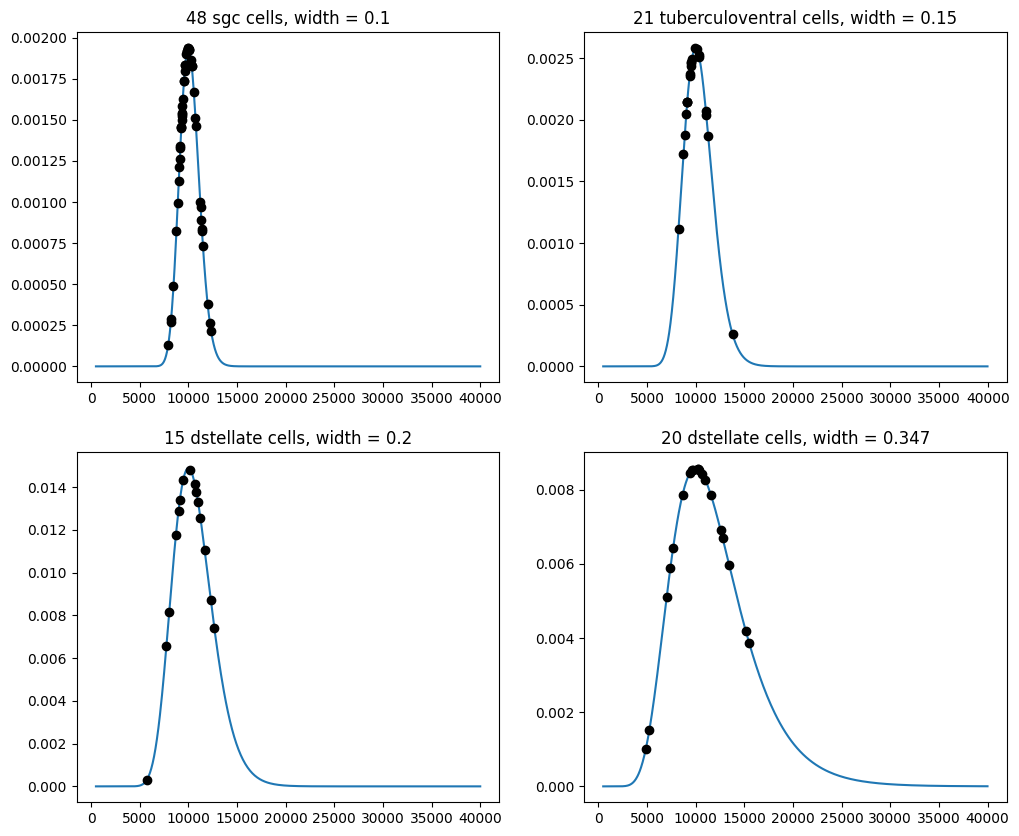

In [46]:
# sgc->pyr, vertical->pyr, dstellate->pyr, dstellate->tstellate
n_connections = [48, 21, 15, 20]
input_range = [0.1, 0.15, 0.2, 0.347]

cf = 10e3

sgc = populations.SGC()
vertical = populations.Tuberculoventral()
dstellate = populations.DStellate()

pops = [sgc, vertical, dstellate, dstellate]

fig, axs = plt.subplots(2,2,figsize=(12,10))
axs = axs.ravel()

for i, pop in enumerate(pops):

    dist = scipy.stats.lognorm(input_range[i], scale=cf)
    full_dist = np.ones(len(pop._cells))

    vals = pop._cells['cf']
    dens = np.diff(vals)
    dens = np.concatenate([dens[:1], dens])
    pdf = dist.pdf(vals) * dens
    full_dist *= pdf / pdf.sum()

    cells = []
    full_dist /= full_dist.sum()
    vals = np.random.uniform(size=n_connections[i])  # draw size samples from a uniform distribution between 0 and 1
    vals.sort()
    cumulative = np.cumsum(full_dist)  # cumulative sum of values
    for val in vals:
        u = np.argwhere(cumulative >= val)  
        if len(u) > 0:
            cell = u[0,0]  # grab first cell index where the corresponding cumulative value is greater than the uniformly random number
            cells.append(cell)

    axs[i].plot(pop._get_cf_array(species='mouse'),full_dist);
    # plt.vlines(vertical._get_cf_array(species='mouse')[cells], ymin=0.001, ymax=0.00125, color='k');
    axs[i].plot(pop._get_cf_array(species='mouse')[cells], full_dist[cells], 'o', color='k');
    axs[i].set_title(f'{len(cells)} {pop.type} cells, width = {input_range[i]}');

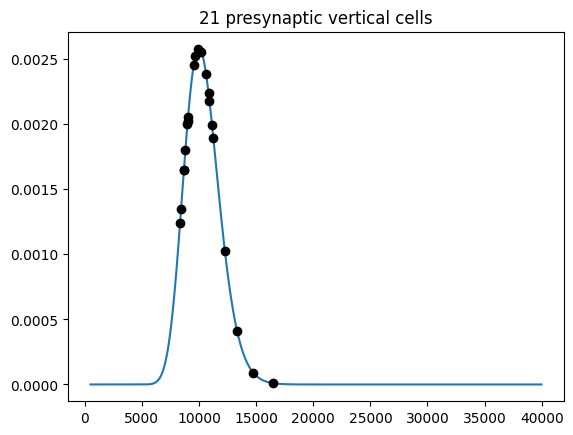

In [38]:
plt.plot(vertical._get_cf_array(species='mouse'),full_dist);
# plt.vlines(vertical._get_cf_array(species='mouse')[cells], ymin=0.001, ymax=0.00125, color='k');
plt.plot(vertical._get_cf_array(species='mouse')[cells], full_dist[cells], 'o', color='k');
plt.title(f'{len(cells)} presynaptic vertical cells');